In [88]:
import pandas as pd
import pickle

# Import the pre-processed dataset and its values mapping
data = pd.read_csv("./dataset_final.csv")
with open('label_mappings.pkl', 'rb') as f: label_mappings = pickle.load(f)

In [90]:
data.columns

Index(['Gender', 'Age', 'Regions', 'Cgpa', 'SleepDuration', 'DietaryHabits',
       'EducationLevel', 'EducationCategory',
       'HaveYouEverHadSuicidalThoughts?', 'StudyHours',
       'FamilyHistoryOfMentalIllness', 'AcademicPressure', 'StudySatisfaction',
       'FinancialStress', 'Depression'],
      dtype='object')

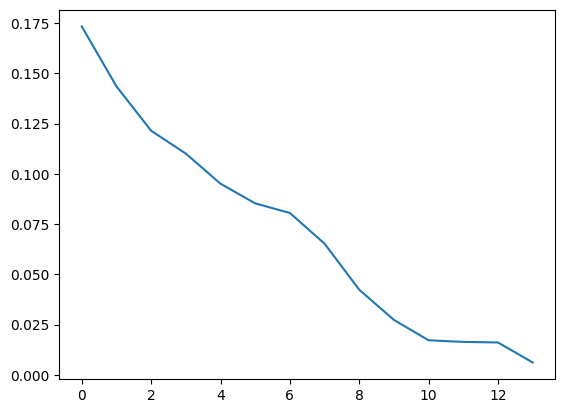

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
random_seed=42
pca=PCA()
d=pca.fit_transform(data.drop(columns="EducationCategory"))
plt.plot(range(data.shape[1]-1), pca.explained_variance_ratio_);



In [92]:
import numpy as np
explained_variances = pca.explained_variance_ratio_

# Sort the explained variance ratios in descending order
sorted_variances = sorted(explained_variances, reverse=True)


# Calculate the cumulative sum of the explained variance ratios
cumulative_variances = np.cumsum(sorted_variances)

# Find the index i of the first principal component where the cumulative sum exceeds 0.05
cutoff_index = np.argmax(cumulative_variances > 0.8)
print("Used the top {} transformed variables".format(cutoff_index))

# Keep the first i principal components and discard the rest
X = pca.transform(data.drop(columns="EducationCategory"))[:, :cutoff_index+1]


Used the top 6 transformed variables


In [ ]:
X

[np.float64(0.1733157857088682),
 np.float64(0.1435255923833712),
 np.float64(0.12143950697927709),
 np.float64(0.11006219365268863),
 np.float64(0.09510250832442657),
 np.float64(0.0853069647032156),
 np.float64(0.08051905125593245),
 np.float64(0.06526241706063715),
 np.float64(0.04233566183687056),
 np.float64(0.02730899255875522),
 np.float64(0.01718142758681775),
 np.float64(0.016393963153002226),
 np.float64(0.01609761681851891),
 np.float64(0.006148317977618404)]

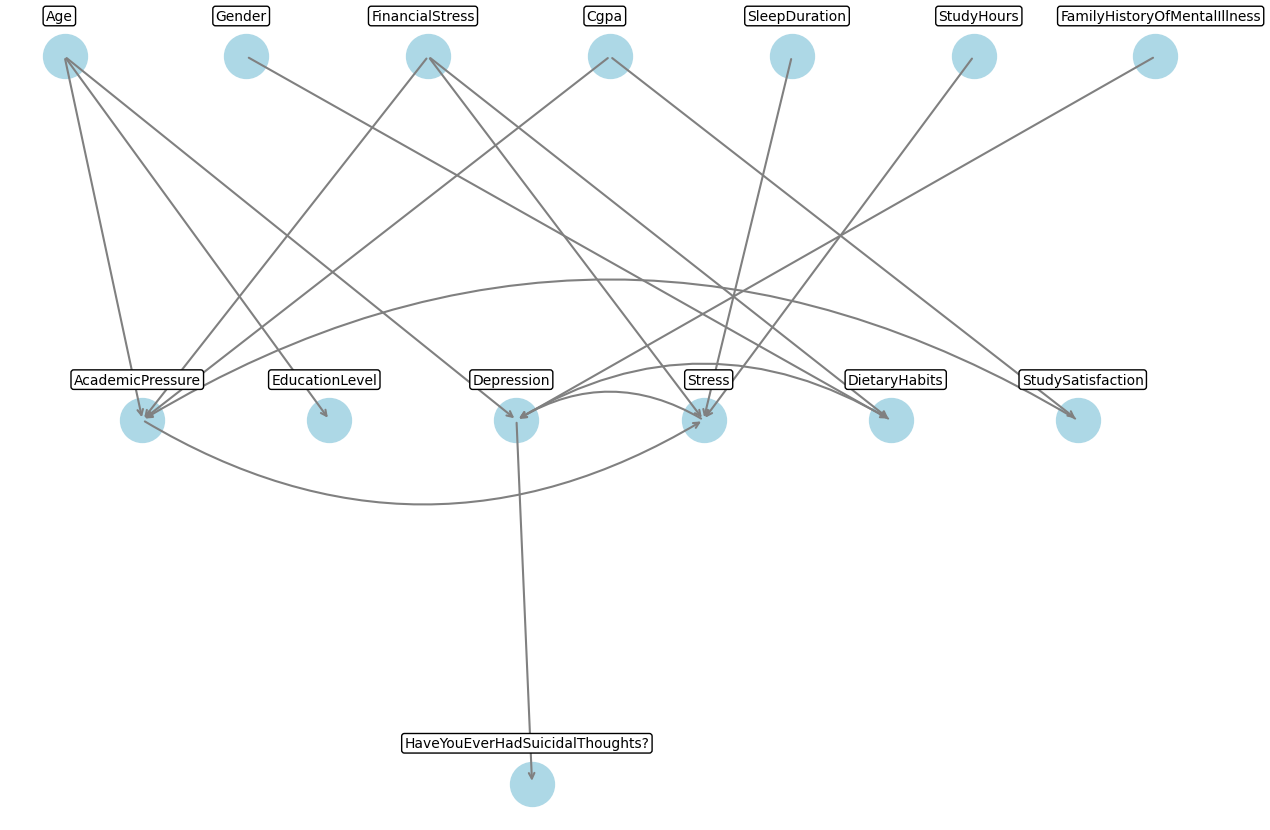

In [ ]:
from pgmpy.models import BayesianNetwork
import networkx as nx
from utils import hierarchical_layout, draw_graph

# Network Giorgio with Stress
network_structure = [
    ("Age","AcademicPressure"),
    ("Age", "EducationLevel"),
    ("Age", "Depression"),
    ("Gender", "DietaryHabits"),
    ("FinancialStress", "AcademicPressure"),
    ("FinancialStress", "Stress"),
    ("FinancialStress", "DietaryHabits"),
    ("Cgpa", "StudySatisfaction"),
    ("Cgpa", "AcademicPressure"),
    ("StudySatisfaction", "AcademicPressure"),
    ("AcademicPressure", "Stress"),
    ("SleepDuration", "Stress"),
    ("StudyHours", "Stress"),
    ("Stress", "Depression"),
    ("DietaryHabits", "Depression"),
    ("FamilyHistoryOfMentalIllness", "Depression"),
    ("Depression", "HaveYouEverHadSuicidalThoughts?")
]

BN = BayesianNetwork(network_structure, latents=["Stress"])

# Plot its graph
G = nx.DiGraph()
G.add_edges_from(BN.edges())
pos = hierarchical_layout(G, horizontal_spacing=3.0)
draw_graph(G, pos)

In [49]:
nodes = sorted([n for n in BN.nodes()])
cols = sorted(data.columns.to_list())
if (nodes != cols) :
    print("Difference:", set(nodes)^set(cols))

Difference: {'Stress', 'EducationCategory', 'Regions'}


In [50]:
import numpy as np
data_new = data.drop(columns=["Regions", "EducationCategory"])

data_new["Stress"] = -1  # the problem is here, what can we set?

nodes = sorted([n for n in BN.nodes()])
cols = sorted(data_new.columns.to_list())
if (nodes != cols) :
    print("Difference:", set(nodes)^set(cols))

In [68]:
from pgmpy.estimators import ExpectationMaximization

# Fit Bayesian Network using Expectation-Maximization
em = ExpectationMaximization(BN, data.drop(columns=["EducationCategory","Regions"]))
random_seed = 42
estimated_params = em.get_parameters(n_jobs=-1, seed=random_seed, max_iter=100)

100%|██████████| 100/100 [06:53<00:00,  4.14s/it]


In [80]:
from pgmpy.factors.discrete.CPD import TabularCPD

def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup

BN.add_cpds(*estimated_params)
BN.check_model()

True

In [74]:
from pgmpy.inference import VariableElimination

exact_infer = VariableElimination(BN)
exact_result = exact_infer.query(  
    variables=['Stress'], 
    evidence={'Age': 2, "AcademicPressure":3}
)

#from pgmpy.sampling import BayesianModelSampling
#sampler = BayesianModelSampling(mod)
#samples = sampler.forward_sample(size=10000)
#filtered_samples = samples[samples['Age'] == 1]
#approx_result = filtered_samples['AcademicPressure'].value_counts(normalize=True)
#
#print("Exact result: ", exact_result)
#print("Approx result: ", approx_result)
#
#from pgmpy.inference import VariableElimination
#exact_infer = VariableElimination(BN)
#exact_result = exact_infer.query(   # P(C|A=1)
#    variables=['AcademicPressure'], 
#    evidence={'Age': 1}
#)
#
#from pgmpy.sampling import BayesianModelSampling
#sampler = BayesianModelSampling(BN)
#samples = sampler.forward_sample(size=10000)
#filtered_samples = samples[samples['Age'] == 1]
#approx_result = filtered_samples['AcademicPressure'].value_counts(normalize=True)

print("Exact result: ", exact_result)
#print("Approx result: ", approx_result)

Exact result:  +-----------+---------------+
| Stress    |   phi(Stress) |
+===========+===============+
| Stress(0) |        0.5329 |
+-----------+---------------+
| Stress(1) |        0.4671 |
+-----------+---------------+


In [78]:
from pgmpy.estimators import PC, HillClimbSearch, AICScore
from pgmpy.metrics import  structure_score, log_likelihood_score
from pgmpy.estimators import AICScore

em.fit()

#log_likelihood_score(BN,  data.drop(columns=["EducationCategory","Regions"]))

AttributeError: 'ExpectationMaximization' object has no attribute 'fit'